# Import

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
# import tqdm
import time
import datetime
import torchvision
from torchvision import transforms as T
from torchvision.io import read_image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tensorflow as tf
from PIL import Image
import cv2
import copy

import csv
import json
import struct
from functools import reduce
import shelve
import shutil
from glob import glob
import os, random
from shutil import copyfile,rmtree

import tensorflow.lite as tflite
import scipy.io as sio
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)


cpu


# model def

In [123]:
def save_map(ch_map):
    tmp = ch_map.cpu().detach().numpy().squeeze()
    sio.savemat('./map.mat',{'Z':tmp})

In [118]:
import torch.nn as nn
import torch.nn.functional as F

class SELayer(nn.Module):
    def __init__(self, in_ch, out_ch, ksize, stride, reduction=16):
        super(SELayer, self).__init__()
#         self.conv = nn.Conv1d(in_channels=in_ch, out_channels=out_ch, 
#                               kernel_size=ksize,stride=stride)
        
        self.conv = nn.Conv1d(in_ch, in_ch, kernel_size=3, 
                                     stride=stride,
                                     groups=in_ch)
        
        self.conv_bn = nn.BatchNorm1d(in_ch)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_ch, in_ch//reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_ch//reduction, in_ch, bias=False),
            nn.Sigmoid()
        )
        self.PC = nn.Conv1d(in_ch, out_ch,  kernel_size=1, stride=1)
        self.PC_bn = nn.BatchNorm1d(out_ch)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.conv_bn(x)
        b, c, l = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        res = x * y.expand_as(x)
#         print(res.shape)
        res = self.PC(res)
        res = self.PC_bn(res)
        return res,y

class CLS_NET(nn.Module):
    def __init__(self,num_classes=2):
        super(CLS_NET, self).__init__()
#         self.head_avgpool = nn.AdaptiveAvgPool1d(1)
#         self.head = nn.Sequential(
#             nn.Linear(48, 48//16, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Linear(48//16, 48, bias=False),
#             nn.Sigmoid()
#         )
        
        self.layers = [
            [48,48,7,2,2],
#             [48,24,5,2,4 ],        
            [48,8, 3,2,4 ],  
        ]
        self.basicblock = []
        for in_ch, out_ch, ksize, stride, reduction in self.layers:
            self.basicblock.append(SELayer(in_ch, out_ch, ksize, stride, reduction))
        self.basicblock = nn.ModuleList(self.basicblock)     
        
        self.fc1 = nn.Linear(504, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU6(inplace=True)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(32, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.relu2 = nn.ReLU6(inplace=True)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(16, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
#         b, c, l = x.size()
#         y = self.head_avgpool(x).view(b, c)
#         x = self.head(y).view(b, c, 1).expand_as(x)*x

        x,ch_map = self.basicblock[0](x) #256 to 128
#         print(x.shape)
        x,_ = self.basicblock[1](x) #128 to 64
#         print(x.shape)
#         x,_ = self.basicblock[2](x) #64 to 32
#         print(x.shape)
        x = x.reshape((-1,504))
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x,ch_map

# dataloader

In [25]:
def data_loader(data_list,batch_size=24):
#     data_list (24, 48, 256)
    label = list(range(data_list.shape[0]))
    if SEED is not None:
        random.seed(SEED)
        random.shuffle(label)
    
    batch = torch.zeros((batch_size,48,256))
    for i in range(batch_size):
        batch[i,:] = data_list[label[i],:,:]
    
    label = np.array(label)
    label[label<12] = 0
    label[label>=12] = 1
    label = torch.tensor(label)
    marks = label.long().to(device)
    return batch,marks

# train funcs

In [26]:
def distiller_epoch(stu_model, criterion, optimizer, scheduler, train_mode, show_tqdm=True):
    if train_mode:
        batch,marks = data_loader(data_cube,24)
        stu_model.train()
    else:
        batch,marks = data_loader(data_cube,24)
        stu_model.eval()

    loss_list = []
    acc_list = []
    loss_tmp = 0
    acc_n = 0
    
    stu_inputs = batch.to(device)
    with torch.set_grad_enabled(train_mode):
        stu_outputs,ch_map = stu_model(stu_inputs)
    
    loss = criterion(stu_outputs,marks).to(device)
    
    stu_mark = torch.argmax(stu_outputs,dim=1)
    for i in range(BATCH_size):
        if stu_mark[i].item() == marks[i].item():
            acc_n+=1
    
    if train_mode:
        loss.backward()
        optimizer.step()
        scheduler.step()

    loss_list += [loss.item()]
    loss_tmp  +=  loss.item()
        
#     this_epoch_loss = loss_tmp / batchnumber
    acc_rate = acc_n/(BATCH_size)
#     print(loss_list,acc_rate)
    return loss_list,acc_rate

In [27]:
def distiller_train(stu_model,epochs,base_lr=0.01, max_lr=0.1,step_size_up=500, step_size_down=500,gamma=1,
                    weight_decay=1e-5, save_path='./stu_model.pt',
                    criterion=nn.CrossEntropyLoss(), show_tqdm=True,
                   all_train_losses=[],all_val_losses=[],all_learn_rate=[],all_rkd=[]):
        
    global EPOCH_idx  # global epoch for tensorboard record index 
    # 优化器
    optimizer = torch.optim.SGD(stu_model.parameters(),
                                lr=base_lr, momentum=0.9, dampening=0, 
                                weight_decay=weight_decay, nesterov=True)
    # 学习率更新策略
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,
                                                  step_size_up=step_size_up, step_size_down=step_size_down,
                                                  mode='exp_range',gamma=gamma)
    best_a = 0
    # 逐epoch训练
    for epoch in tqdm(range(epochs)):
#         print('EPOCH #', epoch+1,end=' ')
#         print('LR: {:0.6f}'.format(optimizer.param_groups[-1]['lr']),end=' ')
        loss_list_t,a_t = distiller_epoch(stu_model, criterion, optimizer, scheduler,
                                      train_mode=True, show_tqdm=show_tqdm)
        loss_list_v,a_v = distiller_epoch(stu_model, criterion, optimizer, scheduler,
                                      train_mode=False, show_tqdm=show_tqdm)
        all_train_losses += [np.mean(loss_list_t[0])]
        all_val_losses += [np.mean(loss_list_v[0])]
        all_learn_rate += [optimizer.param_groups[-1]['lr']]
        all_rkd += [a_t]
#         print(all_rkd)
        if a_v > best_a:
            best_a = a_v
            torch.save(stu_model.state_dict(), save_path)      # epoch的验证loss小于最优loss 保存模型
#             long_pic_tensorboard(val_set_marked,stu_model,col=25,row=16,epochidx=EPOCH_idx)

#         torch.save(stu_model.state_dict(), save_path)        # 每轮都保存模型
        EPOCH_idx+=1
        
    return 

In [28]:
def distiller_train_lr_test(stu_model,epochs,init_lr,lr_rate, times,
                            weight_decay=1e-5,batch_size=128, save_path='./stu_model.pt',
                            criterion=nn.CrossEntropyLoss(), show_tqdm=True,
                            all_train_losses=[],all_val_losses=[],all_learn_rate=[],all_rkd=[]):
    '''训练调度器  
    criterion  切换损失函数模式 
    auto_lr    自动更新学习率开关'''
    best_val_loss = float('inf')
    
    # 优化器
    optimizer = torch.optim.SGD(stu_model.parameters(),
                                lr=init_lr, momentum=0.9, dampening=0, 
                                weight_decay=weight_decay, nesterov=True)
    
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=init_lr, max_lr=init_lr,
                                                  step_size_up=100, step_size_down=100,
                                                  mode='exp_range',gamma=1)
    
    # 逐epoch训练
    for epoch in tqdm(range(epochs)):
        print('EPOCH #', epoch+1,end=' ')
        print('LR:',init_lr)
        tmp = []
        for i in range(times):
            loss_list_t = distiller_epoch(stu_model, criterion, optimizer, scheduler,
                                      train_mode=True, show_tqdm=show_tqdm)
            tmp+=loss_list_t[0]
            
        all_train_losses += [np.mean(tmp)]                   # 拼接进所有训练loss列表 逐batch
        all_learn_rate   += [init_lr]                        # 拼接当前学习率

        if np.mean(tmp)>200 or np.isnan(np.mean(tmp)):
            print(np.mean(tmp))
            break
        init_lr *= lr_rate
        for param_group in optimizer.param_groups:   # 更新所有lr
            param_group['lr'] = init_lr
    return 

# load data

In [29]:
def load_data_from_mat(path):
    data = sio.loadmat(path)
    data_cube = torch.tensor(data['sig2'].squeeze().transpose((2,0,1)))
    return data_cube

# Train

## lr test

In [9]:
# epoch=2000
# start_lr=1e-6
# factor=1.1
# times=1
# # exp test lr 
# # print('start exp test >>> from {} to {}'.format(start_lr,start_lr*(factor**epoch)))
# t_loss, v_loss, l_rate, rkds=[],[],[],[]

# distiller_train_lr_test(stu_model,epoch,start_lr,factor,times,
#                         weight_decay=1e-6,batch_size=BATCH_size, show_tqdm=False,
#                         all_train_losses=t_loss,all_val_losses=v_loss,
#                         all_learn_rate=l_rate,all_rkd=rkds)

In [10]:
# from matplotlib import pyplot as plt
# %pylab inline

# #plot test result
# x = [start_lr*(factor**i) for i in range(len(t_loss))]
# plt.plot(x,np.array(t_loss))
# plt.xscale('log')
# # plt.ylim((0, 2))
# # plt.xlim((1e0, 10**0.2))
# plt.show()

## train

In [129]:
path = './back3_HBR_proc.mat'
stu_model = CLS_NET()
SEED = 1024
BATCH_size = 24
EPOCH_idx = 0           # log epoch index init to 0
data_cube = load_data_from_mat(path)

In [130]:
# batch,marks = data_loader(data_cube,24)
# res,y = stu_model(batch)
# y.shape

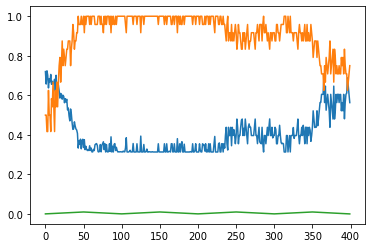

In [131]:
epoch_n = 400
cycle_n = 8
# lrs = 1e4/8
lrs=1
step = epoch_n*(24*2//BATCH_size)/(cycle_n*2)

t_loss, v_loss, l_rate, rkds=[],[],[],[]
distiller_train(stu_model,epoch_n,base_lr=10**(-5)/lrs, max_lr=10**(-2)/lrs,step_size_up=step, step_size_down=step,gamma=1,
                weight_decay=1e-6,show_tqdm=False,all_train_losses=t_loss,all_val_losses=v_loss,
                        all_learn_rate=l_rate,all_rkd=rkds)
plt.plot(t_loss)
plt.plot(rkds)
plt.plot(l_rate)

# Attention map

In [65]:
stu_model.load_state_dict(torch.load('./stu_model.pt')) 

<All keys matched successfully>

In [132]:
SEED = None
data_cube = load_data_from_mat(path)
batch,marks = data_loader(data_cube,24)
res_sort,ch_map = stu_model(batch)
save_map(ch_map)